In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score 

In [2]:
injuryData = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/Injuries.csv")

In [3]:
injuryData.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
injuryData.rename(columns={'Notes': 'Injury Type'}, inplace=True)
injuryData.rename(columns={'Relinquished': 'Player'}, inplace=True)

### We want to separate the dataset by year to get a good idea of the total number of injuries that have occured annually

In [4]:
# Setting the objects in the column to a pandas datetime object
injuryData['Date'] = pd.to_datetime(injuryData['Date'])

#Grouping rows by 'decade' column
injuryData['Year'] = (injuryData['Date'].dt.year)

### Let's now remove all rows where the players have been acquired back from the IL 


In [5]:
# Removing the Acquired column removes all duplicates 
injuryData = injuryData[injuryData['Acquired'].isna()]
del injuryData['Acquired']

### Now let's calculate the total sum of injuries for each Year

In [6]:
# We only want to include data from the years after 1989 
yearly_injuries = {}
total_injuries = 0
for year, group in injuryData.groupby('Year'):
    if year > 1989: 
        injuries = group.shape[0]
        yearly_injuries[year] = injuries
        total_injuries += injuries
#         print(f"Year: {year} Injuries: {injuries}")
#         print(f"Total Injuries: {total_injuries}")
#         print("---------------------------------------------")
        

In [7]:
# Now let's remove all the rows from the data frame that have data before 1990
injuryData = injuryData[injuryData['Year'] >= 1990]

## It is important to note that the NBA did not have and IR/IL until the 1989-1990 season. Prior to this injured players were still members of the active roster. For this reason, it's likely many injuries do not appear in the dataset.

In [28]:
df = pd.DataFrame(yearly_injuries.items(), columns=['Year', 'Injuries'])
df

{1990: 64, 1991: 66, 1992: 28, 1993: 33, 1994: 127, 1995: 245, 1996: 277, 1997: 290, 1998: 157, 1999: 396, 2000: 326, 2001: 335, 2002: 318, 2003: 310, 2004: 356, 2005: 627, 2006: 938, 2007: 962, 2008: 857, 2009: 755, 2010: 883, 2011: 600, 2012: 780, 2013: 634, 2014: 679, 2015: 814, 2016: 835, 2017: 1172, 2018: 1016, 2019: 866, 2020: 570, 2021: 1582, 2022: 1182, 2023: 506}


,Year,Injuries
0,1990,64
1,1991,66
2,1992,28
3,1993,33
4,1994,127
5,1995,245
6,1996,277
7,1997,290
8,1998,157
9,1999,396


Text(0.5, 1.0, 'Number of Injuries Year by Year')

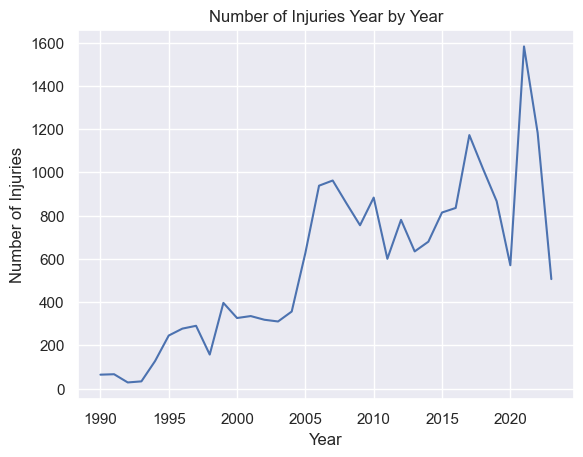

In [29]:
sns.set(style="darkgrid")
sns.lineplot(x=yearly_injuries.keys(), y=yearly_injuries.values(), data=yearly_injuries)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')

In [10]:
unique_values = injuryData['Team'].nunique()
print("Number of unique teams:", unique_values)

Number of unique teams: 33


### Now let's get a Train and a Test set so we can fit out data to a model

### We now have a more accurate dataset representing the total number of injuries from 1990-Present. 

### Let's get the average number of injuries per season over this time span

In [11]:
# Occassionally the Dataframe will not properly remove all irrelevent rows
injury_numbers_list = list(yearly_injuries.values())
avg_inj_per_year = np.mean(injury_numbers_list, axis=0)
print(avg_inj_per_year)
print(np.sum(injury_numbers_list, axis=0))

576.0588235294117
19586


## I'd now like to encode each individual player name, as well as remove the date column

In [12]:
del injuryData['Date']
label_encoder = LabelEncoder()
injuryData['Player']=label_encoder.fit_transform(injuryData['Player'])


In [13]:
injuryData

,ID,Team,Player,Injury Type,Year
728,728,Cavaliers,2392,placed on IL with sprained left knee,1990
730,730,Magic,1139,placed on IL,1990
732,732,Hawks,423,placed on IL,1990
734,734,Hawks,1179,placed on IL,1990
735,735,76ers,1336,placed on IL with shin splints,1990
...,...,...,...,...,...
37624,37624,Grizzlies,960,placed on IL with right hand injury,2023
37625,37625,Grizzlies,1055,placed on IL with sore left elbow,2023
37630,37630,Kings,553,placed on IL with sore left knee,2023
37631,37631,Knicks,2298,placed on IL with illness,2023


+ Due to a there being a lack of true concensus for the number of players in the NBA from 1990-present, I have estimated the total number of players in this time frame based on the number of teams in the league and the number of roster spots each team was allowed 

+ This does not account for players on two way contracts or players signed midseason, so the number is not 100% accurate, simply an estimation

In [14]:
# Total Number of players in the NBA in total(duplicates allowed) & total number of players per year
total_player_instances = 13446
ppy = total_player_instances/33

## Now I'd like to encode my Injury Type section. However, there are some extra words I'd like to remove first

In [15]:
slices_to_remove = ["placed on IL with", "placed on IR with", "placed on disabled list with", "placed on IL for",
                   "placed on IL recovering from", "placed on IL during", "(date approximate)", "(out for season)", "(DTD)", "(out 6-8 weeks)"]

notes_list = list(injuryData["Injury Type"])

# Perform the replacement operation on the list
for i in range(len(notes_list)):
    for slice_to_remove in slices_to_remove:
        notes_list[i] = notes_list[i].replace(slice_to_remove, "")

# Convert the list back to a NumPy array
injuryData["Injury Type"] = np.array(notes_list)

In [16]:
injuryData['Injury Type']=label_encoder.fit_transform(injuryData['Injury Type'])

### Next I decided to create a number of variables to train model on

In [17]:
# Variables for model training
uniq_inj = max(injuryData["Injury Type"]) # max method returns the maximum number, in this case that number is also the total number of unqiue injuries 
uniq_plyr = max(injuryData["Player"])
injury_instances = list(injuryData.shape)[0]
inj_per_plyr = injury_instances/uniq_plyr
inj_per_team = injuryData.groupby('Team')['ID'].count().reset_index()
inj_per_team.columns = ['Team', 'Injury_Count']
inj_list = inj_per_team.to_dict(orient='records')

print(f"Unique Injuries: {uniq_inj}")
print(f"Unique Player Instances: {uniq_plyr}")
print(f"Average number of injuries per player: {inj_per_plyr}")
print(f"Average number of injuries per team: {inj_per_team}")


Unique Injuries: 2622
Unique Player Instances: 2453
Average number of injuries per player: 7.984508764777823
Average number of injuries per team:             Team  Injury_Count
0          76ers           595
1        Blazers           574
2        Bobcats           302
3          Bucks           645
4        Bullets            43
5          Bulls           683
6      Cavaliers           724
7        Celtics           796
8       Clippers           624
9      Grizzlies           656
10         Hawks           698
11          Heat           804
12       Hornets           541
13          Jazz           570
14         Kings           547
15        Knicks           643
16        Lakers           569
17         Magic           632
18     Mavericks           799
19          Nets           712
20       Nuggets           644
21        Pacers           734
22      Pelicans           203
23       Pistons           599
24       Raptors           768
25       Rockets           690
26        Sonics 

In [18]:
# Convertint the list of key-value pairs into a dictionary of values 
inj_dict = {}
for obj in inj_list: 
    inj_dict[obj['Team']] = obj['Injury_Count']

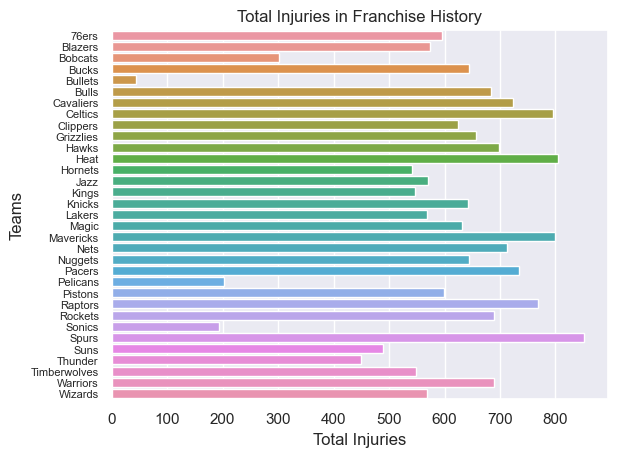

In [19]:
# Bar Graph displaying the total number of injuries per team 

ax = sns.barplot(x=list(inj_dict.values()), y=list(inj_dict.keys()))

# Add labels and title
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8) 
plt.xlabel('Total Injuries')
plt.ylabel('Teams')
plt.title('Total Injuries in Franchise History')

# Display the plot
plt.show()

## Create a scatter plot to see the total number on injuries over 

In [20]:
# Narrowing possible injuries down to the 20 most frequent 
# decoded_labels = label_encoder.inverse_transform(encoded_labels)
injuries = injuryData["Injury Type"]
unique_inj_arr = injuries.value_counts()
sorted_injuries = unique_inj_arr.sort_values(ascending=False)
top_20_injuries = sorted_injuries.head(20)


In [21]:
injuryData

,ID,Team,Player,Injury Type,Year
728,728,Cavaliers,2392,1667,1990
730,730,Magic,1139,2526,1990
732,732,Hawks,423,2526,1990
734,734,Hawks,1179,2526,1990
735,735,76ers,1336,1397,1990
...,...,...,...,...,...
37624,37624,Grizzlies,960,1290,2023
37625,37625,Grizzlies,1055,1462,2023
37630,37630,Kings,553,1477,2023
37631,37631,Knicks,2298,742,2023


In [22]:
# Encoding the Team names
injuryData['Team']=label_encoder.fit_transform(injuryData['Team'])

In [23]:
# `Current Issue, We DO NOT HAVE A X_VAL, Y_VAL outside of the foreloop below

X = injuryData[['Team', 'Year', 'Player', 'Injury Type']]
y = []

for injury_type in top_20_injuries: 
    y_train_arr = np.where(injuryData['Injury Type'] == injury_type, 1, 0)
    y.append(y_train_arr)
y = np.array(y)

In [24]:
reshaped_y = y.T
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# models = {}
# for injury_type, y_train_arr in top_20_injuries:
#     model = RandomForestClassifier()
#     X_train_injury = injuryData[['Team', 'Year', 'Player', 'Injury Type']]
#     model.fit(X_train_injury, y_train_arr)
#     models[injury_type] = model

ValueError: Found input variables with inconsistent numbers of samples: [19586, 20]

In [ ]:
len(models)

In [ ]:
# Using the trained models to predict injury types on the validation set
y_probs = {}
for injury_type, model in models.items():
    y_probs[injury_type] = model.predict_proba(X_val)[:, 1]